# Read Configurations used in Testing

In [1]:
import json

# Read raw JSON.
with open("configs.json", "r") as f:
    raw_configs = json.load(f)


# Convert raw JSON to dictionaries.
configurations = {}

for key, raw_conf in raw_configs.items():
    if "duplicate" in raw_conf:
        continue
    
    # Bandwidth,  coding rate,  frequency,  spreading factor, transmit power
    params = raw_conf["params"]
    conf = {
        "delay_ms": raw_conf["delay_ms"],
        "bandwidth": params[0],
        "coding_Rate": params[1],
        "frequency": params[2],
        "spreading_factor": params[3],
        "transmit_power": params[4],
    }
    configurations[key] = conf

for key, raw_conf in raw_configs.items():
    if "duplicate" in raw_conf:
        configurations[key] = {
            **configurations[raw_conf["duplicate"]],
            "duplicate": raw_conf["duplicate"]
        }


In [2]:
for key in sorted(configurations.keys()):
    print(f"{key}:", configurations[key])

AA: {'delay_ms': 250, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 0}
AB: {'delay_ms': 250, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 4}
AC: {'delay_ms': 500, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 8}
AD: {'delay_ms': 500, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 12}
AE: {'delay_ms': 500, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 16}
AF: {'delay_ms': 500, 'bandwidth': 250000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 20}
AG: {'delay_ms': 500, 'bandwidth': 500000.0, 'coding_Rate': 5, 'frequency': 915000000.0, 'spreading_factor': 8, 'transmit_power': 4}
AH: {'delay_ms': 250, 'bandwidth': 250000.0, 'coding_Rate': 5, 'fr

# Read Log Data

In [3]:
import os

log_directory_prefix = "logs-node"
node_ids = [1, 2, 3]


def read_line(line: str, *, FP_FIXED_POINT_SCALE=100000) -> dict:
    """ Reads a single line from a log file. """
    line = line.strip()
    if line.startswith("CORRUPT: "):
        return {"type": "corrupt"}
    
    if not line.startswith("RECV: ") and not line.startswith("SEND: "):
        return None

    if line.startswith("RECV: "):
        type = "received"
        content = line[len("RECV: "):]
    elif line.startswith("SEND: "):
        type = "sent"
        content = line[len("SEND: "):]
    
    content_no_hash = content[5:]
    fields = content_no_hash.split(",")
    comm_id = fields[0]
    packet_id = int(fields[1])
    source_node_id = int(fields[2])
    dest_node_id = int(fields[3])
    hop_count = int(fields[4])

    index = 5
    hop_data = []
    while index < len(fields):
        node_id = int(fields[index])
        hop_data.append({
            "node_id": node_id,
            "timestamp_ms": int(fields[index + 1]),
            "packet_rssi": int(fields[index + 2]) / FP_FIXED_POINT_SCALE,
            "rssi": int(fields[index + 3]) / FP_FIXED_POINT_SCALE,
            "packet_snr": int(fields[index + 4]) / FP_FIXED_POINT_SCALE,
            "gps_lat": int(fields[index + 5]) / FP_FIXED_POINT_SCALE,
            "gps_lon": int(fields[index + 6]) / FP_FIXED_POINT_SCALE
        })
        index = index + 7
    
    return {
        "type": type,
        "comm_id": comm_id,
        "packet_id": packet_id,
        "source_node_id": source_node_id,
        "dest_node_id": dest_node_id,
        "hop_count": hop_count,
        "hop_data": hop_data,
    }


def read_logs(file: str, lines: list[str]) -> dict:
    """ Reads the lines from a log file. """
    filtered_lines = []
    for line in lines:
        result = read_line(line)
        if result is not None:
            filtered_lines.append(result)
    
    return {
        "file": file,
        "lines": filtered_lines
    }


data: dict[int, dict[str, dict]] = {}
for node_id in node_ids:
    node_data: dict[str, dict[str, dict]] = {}
    for key, conf in configurations.items():
        if "duplicate" in conf:
            continue

        file = os.path.join(f"{log_directory_prefix}{node_id}", f"ZZ{key}.txt")
        with open(file, "r") as f:
            lines = f.readlines()
            node_data[key] = read_logs(file, lines)
    
    for key, conf in configurations.items():
        if "duplicate" in conf:
            node_data[key] = {
                **node_data[conf["duplicate"]],
                "duplicate": conf["duplicate"]
            }

    data[node_id] = node_data



## Filter to the intersection of the logged packets on each node

In [4]:
import numpy as np
from collections import Counter, OrderedDict


def most_common_id(ids):
    counter = Counter(ids)

    most_common_count = -1
    most_common_id = None

    for id in OrderedDict.fromkeys(ids):
        count = counter[id]
        if count > most_common_count:
            most_common_count = count
            most_common_id = id

    return most_common_id


for key, conf in configurations.items():
    # Find the min/max packet IDs for filtering.
    min_packet_id = None
    max_packet_id = None
    for _, node_data in list(data.items()):
        packet_ids = []
        for line in node_data[key]["lines"]:
            if "packet_id" in line:
                packet_ids.append(line["packet_id"])
        
        packet_ids = np.array(packet_ids)
        if len(packet_ids) < 5:
            continue
        
        if min_packet_id is None or max_packet_id is None:
            min_packet_id = np.amin(packet_ids)
            max_packet_id = np.amax(packet_ids)
        else:
            min_packet_id = max(min_packet_id, np.amin(packet_ids))
            max_packet_id = min(max_packet_id, np.amax(packet_ids))
    
    print(key, ":", max_packet_id - min_packet_id)

    # Filter the data.
    for _, node_data in list(data.items()):
        node_conf_data = node_data[key]
        filtered_lines = []
        include = False
        for line in node_conf_data["lines"]:
            if "packet_id" not in line:
                if include:
                    filtered_lines.append(line)
                continue
            
            packet_id = line["packet_id"]
            if packet_id >= min_packet_id and packet_id <= max_packet_id:
                include = True
                filtered_lines.append(line)
            else:
                include = False

        node_conf_data["lines"] = filtered_lines
    
    # Count sent/received/corrupt packets, & determine most common middle node.
    
    for node_id, node_data in list(data.items()):
        node_conf_data = node_data[key]
        sent: int = 0
        received: int = 0
        corrupt: int = 0
        first_recipient_node_ids = []
        for line in node_conf_data["lines"]:
            if line["type"] == "sent":
                sent += 1
                hop_data = line["hop_data"]
                if len(hop_data) > 1:
                    first_recipient_node_ids.append(hop_data[1]["node_id"])
                    
            elif line["type"] == "corrupt":
                corrupt += 1
            elif line["type"] == "received":
                received += 1

        node_conf_data["first_recipient_node_id"] = most_common_id(first_recipient_node_ids)
        node_conf_data["sent_count"] = sent
        node_conf_data["received_count"] = received
        node_conf_data["corrupt_count"] = corrupt
            


AA : 285
AB : 284
AC : 152
AD : 146
AE : 155
AF : 198
AG : 203
AI : 113
AJ : 121
AK : 150
AM : 209
AN : 57
BA : 92
BB : 83
BC : 85
BD : 74
BE : 80
BF : 91
BG : 57
BI : 82
BJ : 75
BK : 94
BM : 85
BN : 77
AH : 284
AL : 284
BH : 83
BL : 83


## Print out summary of all logs

In [5]:
for node_id, node_data in data.items():
    for key, key_data in node_data.items():
        print_data = {
            "first_recipient_node_id": key_data["first_recipient_node_id"],
            "sent_count": key_data["sent_count"],
            "received_count": key_data["received_count"],
            "corrupt_count": key_data["corrupt_count"]
        }
        print(f"{node_id}, {key}: {print_data}")

1, AA: {'first_recipient_node_id': None, 'sent_count': 286, 'received_count': 0, 'corrupt_count': 0}
1, AB: {'first_recipient_node_id': None, 'sent_count': 285, 'received_count': 0, 'corrupt_count': 0}
1, AC: {'first_recipient_node_id': None, 'sent_count': 153, 'received_count': 0, 'corrupt_count': 0}
1, AD: {'first_recipient_node_id': None, 'sent_count': 147, 'received_count': 0, 'corrupt_count': 0}
1, AE: {'first_recipient_node_id': None, 'sent_count': 156, 'received_count': 0, 'corrupt_count': 0}
1, AF: {'first_recipient_node_id': None, 'sent_count': 199, 'received_count': 0, 'corrupt_count': 0}
1, AG: {'first_recipient_node_id': None, 'sent_count': 204, 'received_count': 0, 'corrupt_count': 0}
1, AI: {'first_recipient_node_id': None, 'sent_count': 114, 'received_count': 0, 'corrupt_count': 0}
1, AJ: {'first_recipient_node_id': None, 'sent_count': 122, 'received_count': 0, 'corrupt_count': 0}
1, AK: {'first_recipient_node_id': None, 'sent_count': 151, 'received_count': 0, 'corrupt_c

# Plot Data

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import math


def plot_rect(axes, from_x: int, to_x: int, from_y: float, to_y: float, color: str):
    axes.add_patch(
         matplotlib.patches.Rectangle(
            (from_x, from_y),
            to_x - from_x, to_y,
            color=color
        )
    )


def plot_middle_nodes(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    fig, axes = plt.subplots(1, figsize=(8, 4))
    axes.set_title(f"Recipients of Packets Directly from Node 1 as {x_param_name} is Changed")
    axes.set_xlabel(x_param_name)
    axes.set_ylim((0, 4))

    for prefix_index, (prefix, prefix_name) in enumerate(prefixes):

        target_xs = {}
        target_first_recipient_node_ids = {}
        for target_node_id in target_node_ids:
            target_data = data[target_node_id]
            x = []
            first_recipient_node_ids = []
            for suffix in suffixes:
                key = f"{prefix}{suffix}"
                if target_data[key]["received_count"] > 0:
                    first_recipient_node_id = target_data[key]["first_recipient_node_id"]
                else:
                    first_recipient_node_id = float("nan")

                x.append(configurations[key][x_param])
                first_recipient_node_ids.append(first_recipient_node_id)
        
            target_xs[target_node_id] = x
            target_first_recipient_node_ids[target_node_id] = first_recipient_node_ids

        x = []
        y = []
        for index, _ in enumerate(suffixes):
            all_2_middle = True
            all_3_middle = True
            for target_node_id in target_node_ids:
                suffix_x = target_xs[target_node_id][index]
                first_recipient_node_id = target_first_recipient_node_ids[target_node_id][index]
                if math.isnan(first_recipient_node_id):
                    continue

                if first_recipient_node_id != 2:
                    all_2_middle = False
                if first_recipient_node_id != 3:
                    all_3_middle = False
            
            x.append(suffix_x)
            if all_2_middle and all_3_middle:
                # No data.
                y.append(float("nan"))
            elif all_3_middle:
                y.append(3)
            elif all_2_middle:
                y.append(1)
            else:
                y.append(2)
        
        color = ["blue", "green"][prefix_index]
        axes.plot(x, y, label=f"{prefix_name}", color=color)

    axes.legend()
    if log_x_axis:
        axes.set_xscale("log")
        axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axes.get_xaxis().set_tick_params(which='minor', size=0)
        axes.get_xaxis().set_tick_params(which='minor', width=0) 

    axes.set_xticks(x)
    axes.set_yticks([1, 2, 3], ['Node 2', 'Both', 'Node 3'])
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(y=3, color='gray', linestyle='--', linewidth=0.5)
    plt.savefig(f"graphs/middle_node_by_{x_param}.png")



def plot_pdr_with_middle_nodes(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    fig, all_axes = plt.subplots(len(prefixes), figsize=(12, 6 * len(prefixes)))

    source_data = data[source_node_id]
    for prefix_index, ((prefix, prefix_name), axes) in enumerate(zip(prefixes, all_axes)):
        axes.set_title(f"PDR as {x_param_name} is changed ({prefix_name})")
        axes.set_ylabel("Packet Delivery Rate (%)")
        axes.set_xlabel(x_param_name)
        axes.set_ylim((0, 100))

        target_xs = {}
        target_first_recipient_node_ids = {}
        for target_node_id in target_node_ids:
            target_data = data[target_node_id]
            x = []
            y = []
            first_recipient_node_ids = []
            for suffix in suffixes:
                key = f"{prefix}{suffix}"
                sent = source_data[key]["sent_count"]
                received = target_data[key]["received_count"]
                first_recipient_node_id = target_data[key]["first_recipient_node_id"]
                pdr = received / sent
                x.append(configurations[key][x_param])
                y.append(100 * pdr)
                first_recipient_node_ids.append(first_recipient_node_id)
        
            color = ["blue", "green"][prefix_index]
            linestyle = ["solid", "dashed"][target_node_id - 2]
            axes.plot(x, y, label=f"Node {target_node_id}", color=color, linestyle=linestyle)

            target_xs[target_node_id] = x
            target_first_recipient_node_ids[target_node_id] = first_recipient_node_ids

        np_x = np.array(x)
        x_stride = np.median(np_x[:-1] - np_x[1:])
        for index, _ in enumerate(suffixes):
            all_2_middle = True
            all_3_middle = True
            for target_node_id in target_node_ids:
                suffix_x = target_xs[target_node_id][index]
                first_recipient_node_id = target_first_recipient_node_ids[target_node_id][index]
                if first_recipient_node_id != 2:
                    all_2_middle = False
                if first_recipient_node_id != 3:
                    all_3_middle = False
            
            if all_2_middle:
                continue

            colour = ("#ffe3e3" if all_3_middle else "#fffce3")
            from_x = suffix_x - x_stride / 2
            to_x = suffix_x + x_stride / 2
            plot_rect(axes, from_x, to_x, 0, 100, colour)

        axes.legend()
        if log_x_axis:
            axes.set_xscale("log")
            axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axes.get_xaxis().set_tick_params(which='minor', size=0)
            axes.get_xaxis().set_tick_params(which='minor', width=0) 

        axes.set_xticks(x)


def plot_received(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    plt.figure(figsize=(12, 6))
    plt.title(f"Received Packets as {x_param_name} is changed")
    plt.ylabel("Additional packets received by node 2 over node 3 (%)")
    plt.xlabel(x_param_name)
    plt.ylim((-100, 100))
    
    source_data = data[source_node_id]
    for prefix_index, (prefix, prefix_name) in enumerate(prefixes):
        x = []
        y = []
        for suffix in suffixes:
            key = f"{prefix}{suffix}"
            sent = source_data[key]["sent_count"]
            node_2_received = 0
            node_3_received = 0
            for index, target_node_id in enumerate(target_node_ids):
                target_data = data[target_node_id]
                received = target_data[key]["received_count"]
                if index == 0:
                    x.append(configurations[key][x_param])
                if target_node_id == 2:
                    node_2_received = received
                elif target_node_id == 3:
                    node_3_received = received
                else:
                    raise Exception("This function only supports nodes 2 and 3 as targets")
            
            if sent == 0:
                y.append(float("nan"))
            else:
                y.append(100 * (node_2_received - node_3_received) / sent)
            
        color = ["blue", "green"][prefix_index]
        plt.plot(x, y, label=f"{prefix_name}", color=color)
        
    plt.legend()
    if log_x_axis:
        plt.gca().set_xscale("log")
        plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
        plt.gca().get_xaxis().set_tick_params(which='minor', width=0) 

    plt.xticks(x)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.savefig(f"graphs/received_by_{x_param}.png")


def plot_pdr(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    plt.figure(figsize=(12, 6))
    plt.title(f"PDR as {x_param_name} is changed")
    plt.ylabel("Packet Delivery Rate (%)")
    plt.xlabel(x_param_name)
    plt.ylim((0, 100))

    source_data = data[source_node_id]
    for prefix_index, (prefix, prefix_name) in enumerate(prefixes):
        for target_node_id in target_node_ids:
            target_data = data[target_node_id]
            x = []
            y = []
            for suffix in suffixes:
                key = f"{prefix}{suffix}"
                sent = source_data[key]["sent_count"]
                received = target_data[key]["received_count"]
                pdr = received / sent
                x.append(configurations[key][x_param])
                y.append(100 * pdr)
            
            color = ["blue", "green"][prefix_index]
            linestyle = ["solid", "dashed"][target_node_id - 2]
            plt.plot(x, y, label=f"Node {target_node_id}, {prefix_name}", color=color, linestyle=linestyle)

    plt.legend()
    if log_x_axis:
        plt.gca().set_xscale("log")
        plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
        plt.gca().get_xaxis().set_tick_params(which='minor', width=0) 

    plt.xticks(x)
    plt.savefig(f"graphs/pdr_by_{x_param}.png")



def plot_corruption_rate(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    plt.figure(figsize=(12, 6))
    plt.title(f"Packet Corruption as {x_param_name} is changed")
    plt.ylabel("Packet Corruption Rate (%)")
    plt.xlabel(x_param_name)
    plt.ylim((0, 100))

    for prefix_index, (prefix, prefix_name) in enumerate(prefixes):
        for target_node_id in target_node_ids:
            target_data = data[target_node_id]
            x = []
            y = []
            for suffix in suffixes:
                key = f"{prefix}{suffix}"
                received = target_data[key]["received_count"]
                corrupt = target_data[key]["corrupt_count"]
                if received + corrupt > 0:
                    corruption_rate = corrupt / (received + corrupt)
                else:
                    corruption_rate = float("nan")
                x.append(configurations[key][x_param])
                y.append(100 * corruption_rate)
            
            color = ["blue", "green"][prefix_index]
            linestyle = ["solid", "dashed"][target_node_id - 2]
            plt.plot(x, y, label=f"Node {target_node_id}, {prefix_name}", color=color, linestyle=linestyle)

    plt.legend()
    if log_x_axis:
        plt.gca().set_xscale("log")
        plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
        plt.gca().get_xaxis().set_tick_params(which='minor', width=0) 

    plt.xticks(x)
    plt.savefig(f"graphs/packet_corruption_by_{x_param}.png")




def plot_send_times(
        suffixes, x_param, x_param_name, *,
        prefixes=[("A", "Outside"), ("B", "Inside")],
        source_node_id=1, target_node_ids=[2, 3],
        log_x_axis=False
):
    plt.figure(figsize=(12, 6))
    plt.title(f"Time Taken to Transmit Packets as {x_param_name} is Changed")
    plt.ylabel("Time Taken (ms)")
    plt.xlabel(x_param_name)

    source_data = data[source_node_id]
    max_y = None
    for prefix_index, (prefix, prefix_name) in enumerate(prefixes):

        x = []
        y = []
        for suffix in suffixes:
            key = f"{prefix}{suffix}"
            lines = source_data[key]["lines"]
            packet_nos = []
            timestamps = []
            for line in lines:
                packet_nos.append(line["packet_id"])
                timestamps.append(line["hop_data"][0]["timestamp_ms"])
            
            delay = (np.amax(timestamps) - np.amin(timestamps)) / (np.amax(packet_nos) - np.amin(packet_nos))
            x.append(configurations[key][x_param])
            y.append(delay - configurations[key]["delay_ms"])
            
        color = ["blue", "green"][prefix_index]
        plt.plot(x, y, label=f"{prefix_name}", color=color)
        if max_y is None or np.amax(y) > max_y:
            max_y = np.amax(y)

    plt.ylim((0, 100 * (1 + math.ceil(max_y / 100.0))))
    plt.legend()
    if log_x_axis:
        plt.gca().set_xscale("log")
        plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
        plt.gca().get_xaxis().set_tick_params(which='minor', width=0) 

    plt.xticks(x)
    plt.savefig(f"graphs/send_times_by_{x_param}.png")


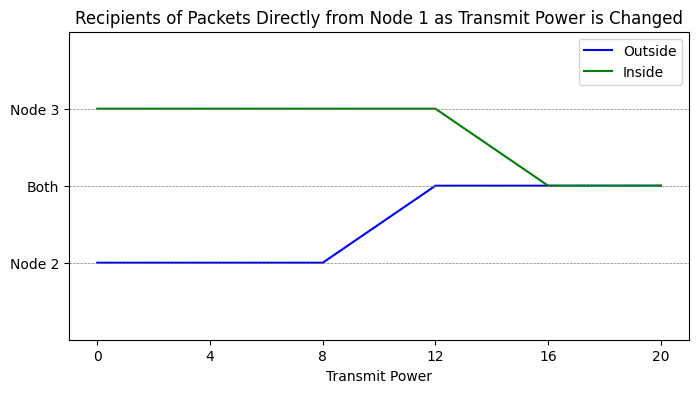

In [7]:
plot_middle_nodes(list("ABCDEF"), "transmit_power", "Transmit Power")

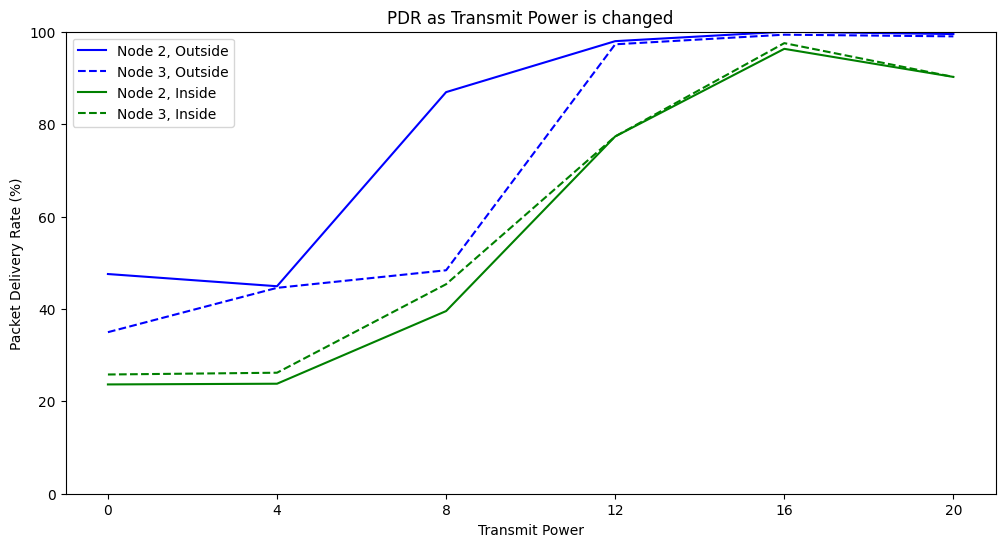

In [8]:
plot_pdr(list("ABCDEF"), "transmit_power", "Transmit Power")

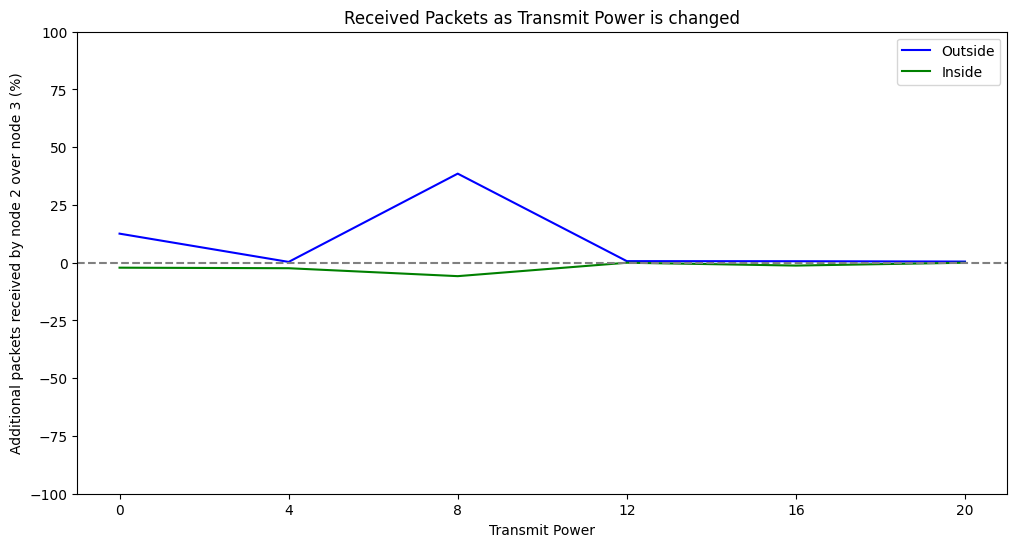

In [9]:
plot_received(list("ABCDEF"), "transmit_power", "Transmit Power")

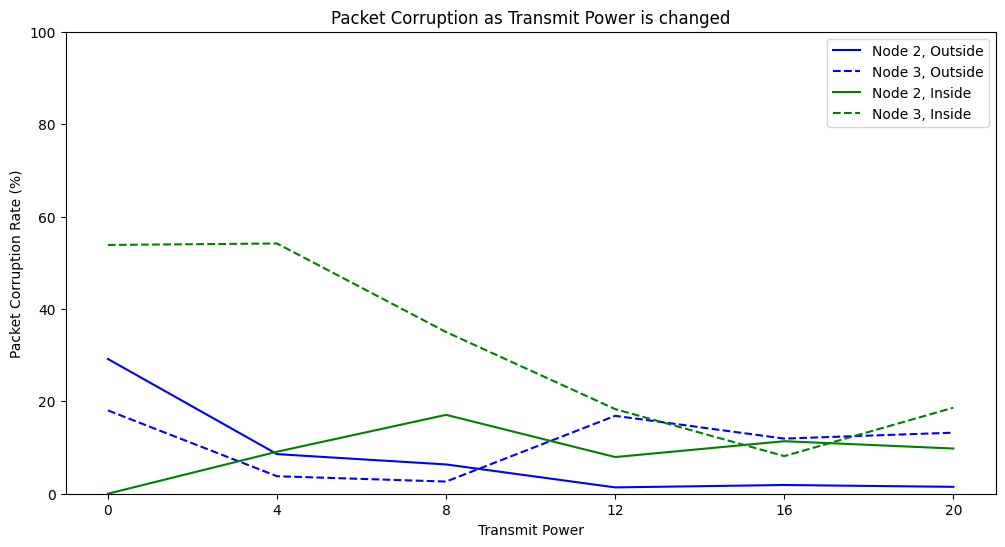

In [10]:
plot_corruption_rate(list("ABCDEF"), "transmit_power", "Transmit Power")

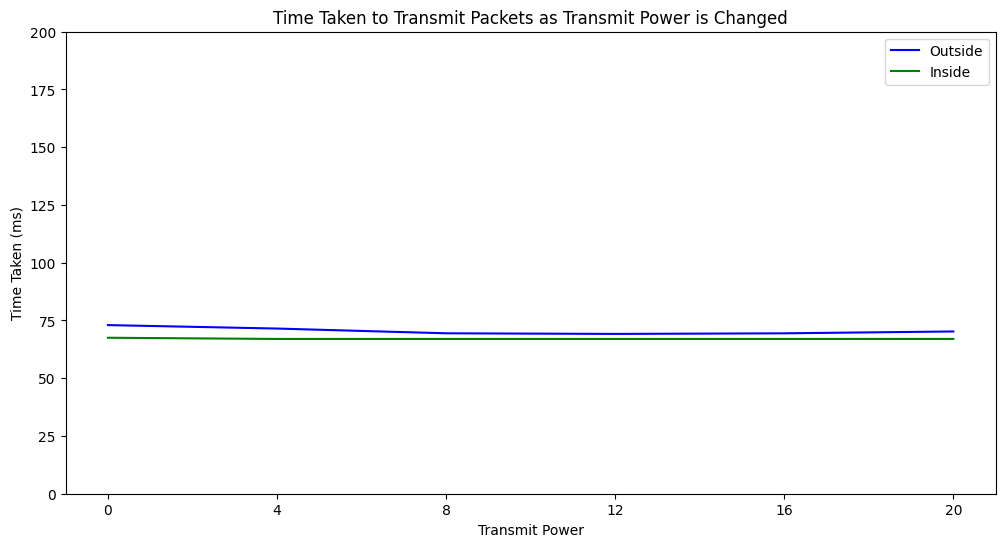

In [11]:
plot_send_times(list("ABCDEF"), "transmit_power", "Transmit Power")

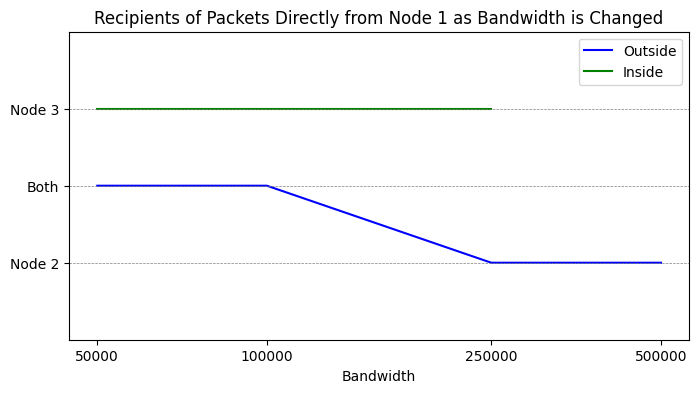

In [12]:
plot_middle_nodes(list("GHIJ"), "bandwidth", "Bandwidth", log_x_axis=True)

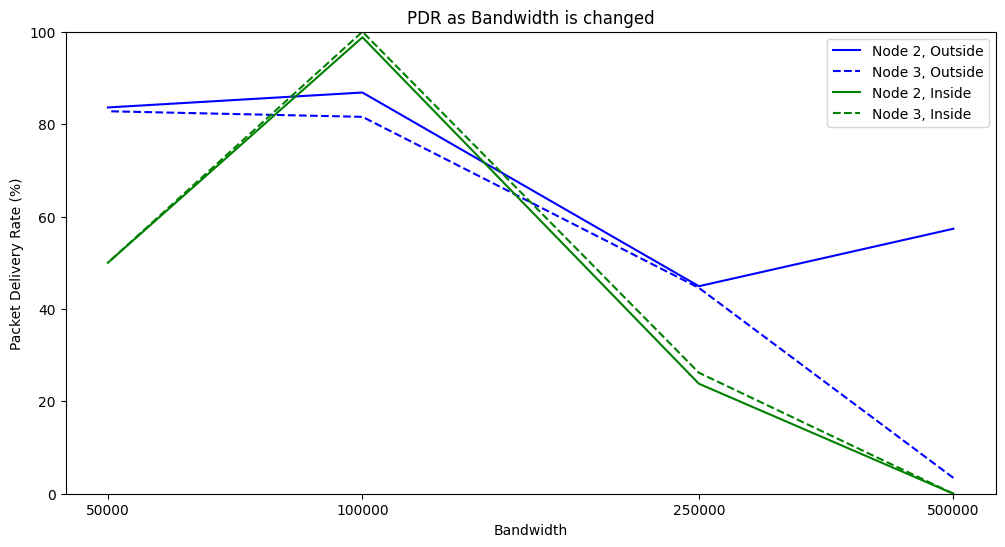

In [13]:
plot_pdr(list("GHIJ"), "bandwidth", "Bandwidth", log_x_axis=True)

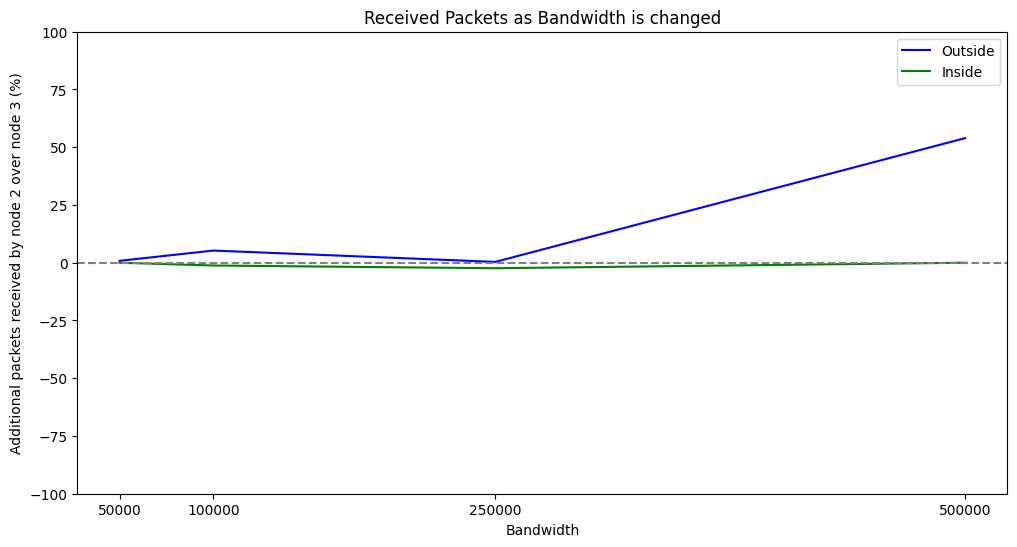

In [14]:
plot_received(list("GHIJ"), "bandwidth", "Bandwidth")

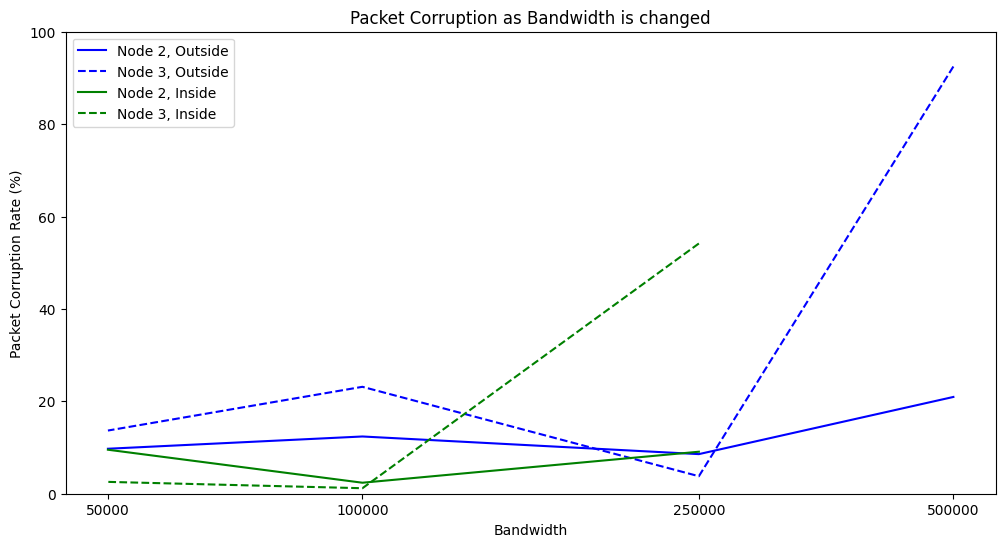

In [15]:
plot_corruption_rate(list("GHIJ"), "bandwidth", "Bandwidth", log_x_axis=True)

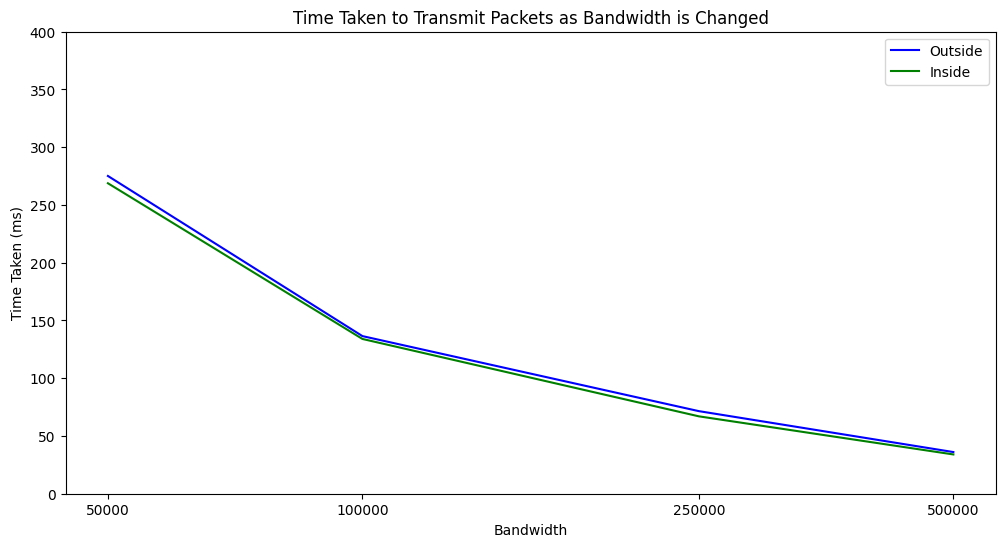

In [16]:
plot_send_times(list("GHIJ"), "bandwidth", "Bandwidth", log_x_axis=True)

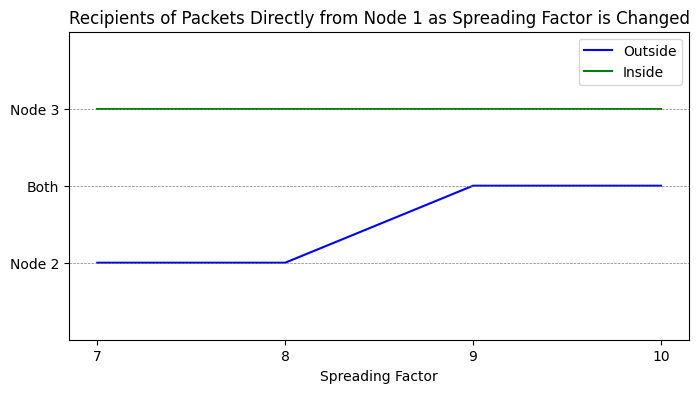

In [17]:
plot_middle_nodes(list("KLMN"), "spreading_factor", "Spreading Factor")

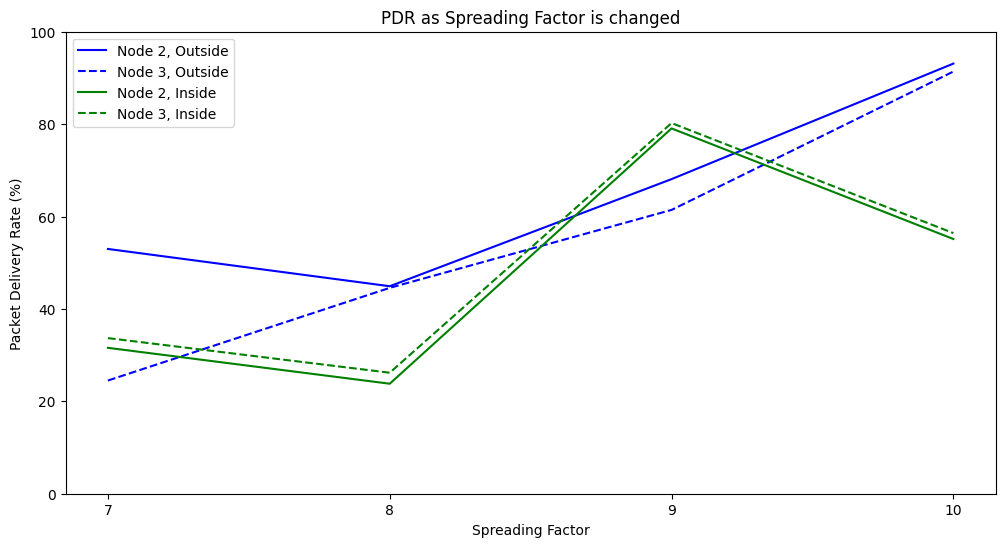

In [18]:
plot_pdr(list("KLMN"), "spreading_factor", "Spreading Factor")

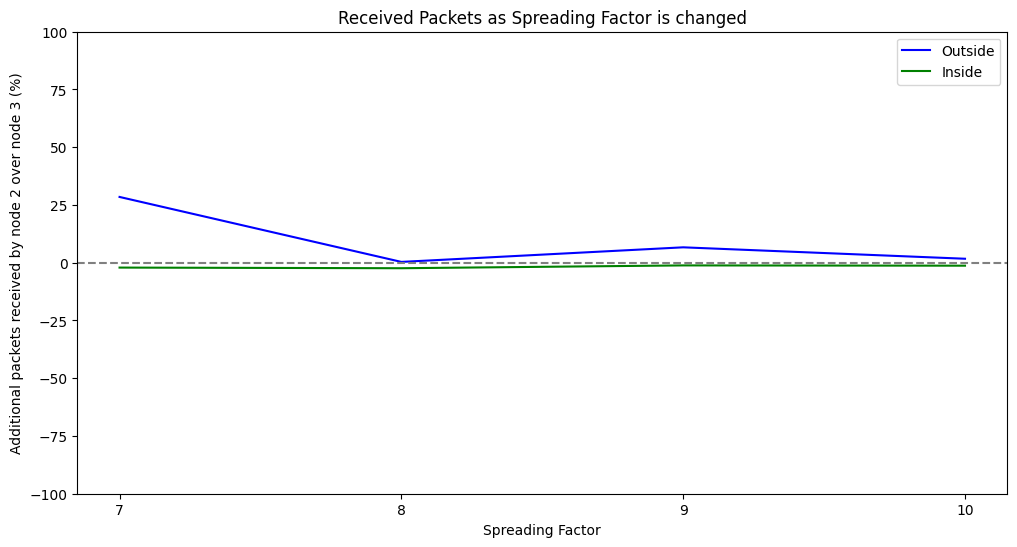

In [19]:
plot_received(list("KLMN"), "spreading_factor", "Spreading Factor")

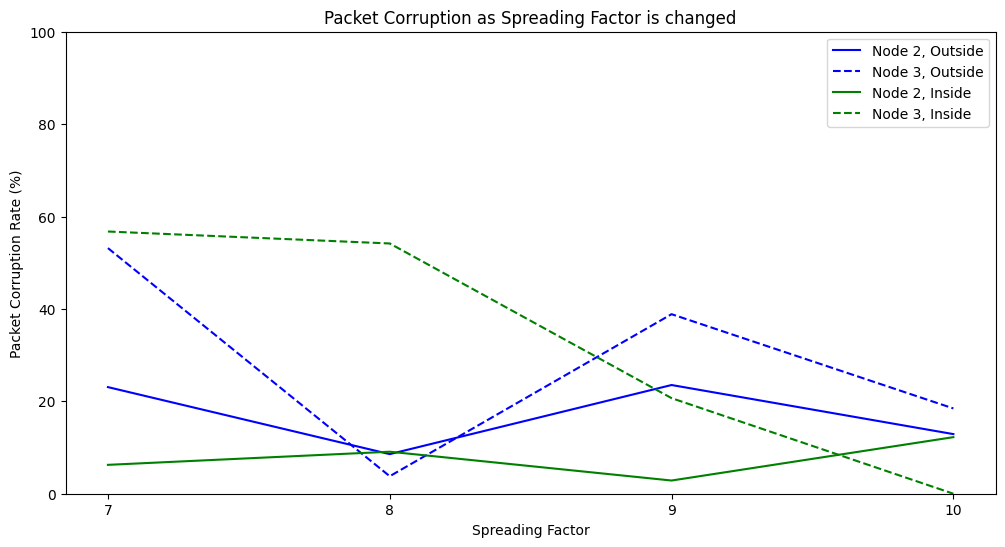

In [20]:
plot_corruption_rate(list("KLMN"), "spreading_factor", "Spreading Factor")

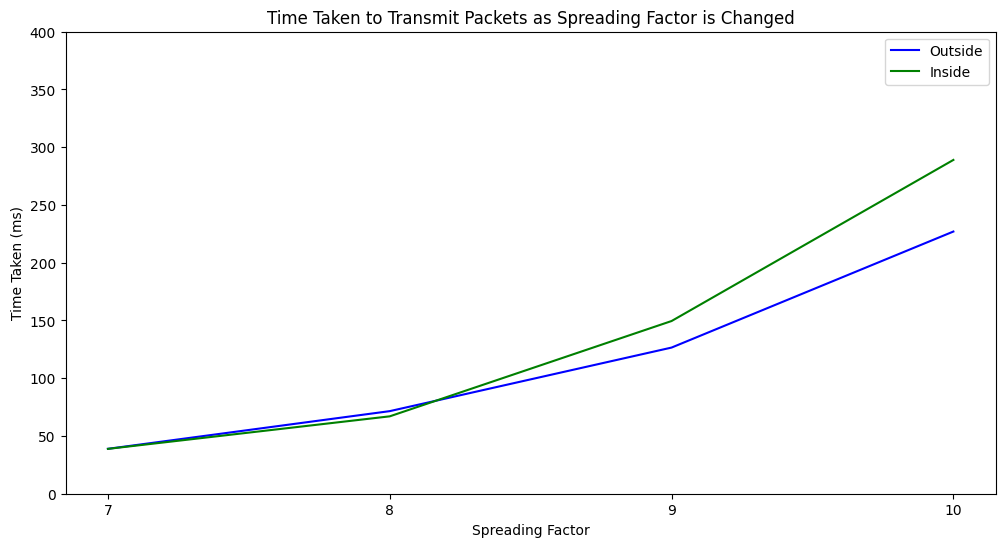

In [21]:
plot_send_times(list("KLMN"), "spreading_factor", "Spreading Factor")